# Hit-Competition Study at High Track Density

**Goal**: Validate whether the Hamiltonian's $\gamma$ term successfully
resolves hit-sharing ambiguities (segment competition) as track density
increases.

The classical matrix-inversion solution $Ax = b$ produces continuous
activations $x_i \in [0, 1]$. Segments sharing a hit should suppress
each other through the linear system coupling. This notebook explicitly
tests that mechanism.

**Study outline:**
1. **Hit occupancy** — how many candidate segments use each hit?
2. **Activation spectrum** — $x_i$ distributions for true vs false segments
3. **Per-hit competition** — true segment activation vs false competitor sum
4. **Track-level reconstruction** — efficiency / ghost rate vs density
5. **Threshold sensitivity** — ROC-like curves at different densities


In [1]:
# ── imports ──────────────────────────────────────────────────────
import json, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

from lhcb_velo_toy.generation import PlaneGeometry, StateEventGenerator
from lhcb_velo_toy.solvers import SimpleHamiltonianFast, get_tracks, construct_event
from lhcb_velo_toy.analysis import EventValidator, Match

# Prevent RecursionError in track-finding DFS at high density
sys.setrecursionlimit(10_000)

%matplotlib inline
plt.rcParams["figure.dpi"] = 120
plt.rcParams.update({
    'font.size': 12, 'axes.labelsize': 13, 'axes.titlesize': 13,
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'legend.fontsize': 10,
    'axes.linewidth': 1.1, 'lines.linewidth': 2, 'lines.markersize': 7,
})

# ── output + save helpers ─────────────────────────────────────────
RUN_TAG = time.strftime("%Y%m%d_%H%M%S")
OUTPUT_ROOT = Path("hit_competition_outputs")
OUTDIR = OUTPUT_ROOT / RUN_TAG
DATA_DIR = OUTDIR / "data"
FIG_DIR = OUTDIR / "figures"
EVENT_DIR = OUTDIR / "events"
for d in (DATA_DIR, FIG_DIR, EVENT_DIR):
    d.mkdir(parents=True, exist_ok=True)

def to_jsonable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.generic):
        return obj.item()
    if isinstance(obj, dict):
        return {str(k): to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(v) for v in obj]
    return obj

def save_json(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(to_jsonable(obj), f, indent=2)

def save_fig(fig, name):
    fig.savefig(FIG_DIR / f"{name}.png", bbox_inches="tight")

# ── reusable helpers ────────────────────────────────────────────
def make_geometry(n_modules=5, z_first=100.0, z_spacing=33.0,
                  half_x=50.0, half_y=50.0):
    z_positions = [z_first + i * z_spacing for i in range(n_modules)]
    return PlaneGeometry(
        module_id=list(range(n_modules)),
        lx=[half_x] * n_modules,
        ly=[half_y] * n_modules,
        z=z_positions,
    )

def generate_event(geo, n_tracks, measurement_error=0.0, collision_noise=1e-8,
                   phi_max=0.2, theta_max=0.2):
    gen = StateEventGenerator(
        detector_geometry=geo, events=1, n_particles=[n_tracks],
        phi_min=-phi_max, phi_max=phi_max,
        theta_min=-theta_max, theta_max=theta_max,
        measurement_error=measurement_error,
        collision_noise=collision_noise,
    )
    gen.generate_random_primary_vertices({"x": 0.1, "y": 0.1, "z": 50.0})
    particles = [[{"type": "pion", "mass": 139.6, "q": 1}] * n_tracks]
    gen.generate_particles(particles)
    return gen, gen.generate_complete_events()

def compute_epsilon(sigma_res, sigma_scatt, dz, scale=1.0, theta_min=1.5e-5):
    theta_s = scale * sigma_scatt
    theta_r = np.arctan((scale * sigma_res) / dz) if dz != 0 else 0.0
    return float(np.sqrt(2 * theta_s**2 + 12 * theta_r**2 + 2 * theta_min**2))

def label_segments(ham, event):
    """Boolean array: True for segments matching a truth-track pair."""
    true_seg_set = set()
    for trk in event.tracks:
        hids = trk.hit_ids
        for k in range(len(hids) - 1):
            true_seg_set.add((hids[k], hids[k + 1]))
    return np.array([
        ham._segment_to_hit_ids[i] in true_seg_set
        for i in range(ham.n_segments)
    ])

def build_hit_to_segments(ham):
    """Dict: hit_id -> list of segment indices using that hit."""
    h2s = defaultdict(list)
    for idx, (fid, tid) in enumerate(ham._segment_to_hit_ids):
        h2s[fid].append(idx)
        h2s[tid].append(idx)
    return dict(h2s)

def safe_generate(geo, n_tracks, collision_noise=1e-8,
                  phi_max=0.2, theta_max=0.2):
    """Generate event, retrying until all tracks have >= 3 hits."""
    for _ in range(20):
        _, event = generate_event(geo, n_tracks,
                                  collision_noise=collision_noise,
                                  phi_max=phi_max, theta_max=theta_max)
        if min(len(t.hit_ids) for t in event.tracks) >= 3:
            return event
    return event  # best effort

# ── segment-pair angle helpers (shared with characterisation) ───
def pairwise_angle(h_prev, h_mid, h_next):
    """Angle between segment (prev->mid) and segment (mid->next).

    This is exactly what the Hamiltonian evaluates for segment pairs
    sharing a middle hit.
    """
    v1 = np.array([h_mid.x - h_prev.x, h_mid.y - h_prev.y, h_mid.z - h_prev.z])
    v2 = np.array([h_next.x - h_mid.x, h_next.y - h_mid.y, h_next.z - h_mid.z])
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1 == 0 or n2 == 0:
        return 0.0
    cos_a = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return float(np.arccos(cos_a))

def collect_segment_pair_angles(event):
    """Collect pairwise angles for ALL segment pairs sharing a middle hit.

    A 'true' pair means all 3 hits (prev, mid, next) are on the SAME track.
    Returns (true_angles, false_angles) as lists.
    """
    hits_dict = {h.hit_id: h for h in event.hits}

    # Build true segment set
    true_seg_set = set()
    for trk in event.tracks:
        hids = trk.hit_ids
        for k in range(len(hids) - 1):
            true_seg_set.add((hids[k], hids[k + 1]))

    # Group hits by module
    hits_by_module = {}
    for h in event.hits:
        hits_by_module.setdefault(h.module_id, []).append(h)
    sorted_mod_ids = sorted(hits_by_module.keys())

    true_angles = []
    false_angles = []

    # For each MIDDLE module, pair incoming and outgoing segments
    for mi in range(1, len(sorted_mod_ids) - 1):
        mod_prev = sorted_mod_ids[mi - 1]
        mod_mid  = sorted_mod_ids[mi]
        mod_next = sorted_mod_ids[mi + 1]

        for h_mid in hits_by_module[mod_mid]:
            for h_prev in hits_by_module[mod_prev]:
                seg_in_true = (h_prev.hit_id, h_mid.hit_id) in true_seg_set

                for h_next in hits_by_module[mod_next]:
                    seg_out_true = (h_mid.hit_id, h_next.hit_id) in true_seg_set
                    angle = pairwise_angle(h_prev, h_mid, h_next)

                    if (seg_in_true and seg_out_true and
                            h_prev.track_id is not None and
                            h_prev.track_id == h_mid.track_id == h_next.track_id):
                        true_angles.append(angle)
                    else:
                        false_angles.append(angle)

    return true_angles, false_angles

print(f"All imports and helpers loaded. Output dir: {OUTDIR}")

All imports and helpers loaded. Output dir: hit_competition_outputs/20260225_115618


In [2]:
# ── physics parameters (same as characterisation notebook) ──────
SIGMA_RES   = 0.0      # mm  (perfect resolution)
SIGMA_SCATT = 1e-4     # rad (0.1 mrad multiple scattering)
DZ_MM       = 33.0     # mm  (module spacing)
SCALE       = 3.0      # accept within 3 sigma

EPSILON   = compute_epsilon(SIGMA_RES, SIGMA_SCATT, DZ_MM, scale=SCALE)
GAMMA     = 1.5        # self-interaction (diagonal penalty)
DELTA     = 1.0        # bias term
BASELINE  = DELTA / (DELTA + GAMMA)
THRESHOLD = (1 + BASELINE) / 2

geo = make_geometry(5, z_spacing=DZ_MM)

# density sweep settings
TRACK_DENSITIES = [5, 10, 20, 30, 50, 75, 100, 150]
N_REPEATS       = 5

# ── angle sweep settings ─────────────────────────────────────────
ANGLE_SETTINGS = [0.2, 0.1, 0.04]   # phi_max = theta_max (symmetric)
ANGLE_LABELS   = {a: f"±{a}" for a in ANGLE_SETTINGS}
ANGLE_COLORS   = {0.2: "royalblue", 0.1: "darkorange", 0.04: "forestgreen"}
ANGLE_MARKERS  = {0.2: "o", 0.1: "s", 0.04: "D"}

print(f"epsilon   = {EPSILON*1e3:.3f} mrad")
print(f"gamma     = {GAMMA},  delta = {DELTA}")
print(f"baseline  = {BASELINE:.3f},  threshold = {THRESHOLD:.3f}")
print(f"Densities : {TRACK_DENSITIES}")
print(f"Repeats   : {N_REPEATS}")
print(f"Angle settings (phi_max = theta_max): {ANGLE_SETTINGS}")

save_json({
    "epsilon": EPSILON,
    "gamma": GAMMA,
    "delta": DELTA,
    "baseline": BASELINE,
    "threshold": THRESHOLD,
    "dz_mm": DZ_MM,
    "sigma_res": SIGMA_RES,
    "sigma_scatt": SIGMA_SCATT,
    "scale": SCALE,
    "track_densities": TRACK_DENSITIES,
    "n_repeats": N_REPEATS,
    "angle_settings": ANGLE_SETTINGS,
}, DATA_DIR / "run_config.json")

epsilon   = 0.425 mrad
gamma     = 1.5,  delta = 1.0
baseline  = 0.400,  threshold = 0.700
Densities : [5, 10, 20, 30, 50, 75, 100, 150]
Repeats   : 5
Angle settings (phi_max = theta_max): [0.2, 0.1, 0.04]


---
## Step 1 — Single-Hit Occupancy Analysis

For each hit, count how many candidate segments in the Hamiltonian use it.
A hit on module $k$ (internal) participates in segments from layer-pair
$(k{-}1, k)$ and $(k, k{+}1)$.  With $n$ tracks per layer the expected
occupancy is $\sim 2n$ for internal hits.

We compare three generation angle settings (phi = theta):
**±0.2**, **±0.1**, and **±0.04** rad.
Narrower angles concentrate tracks → more hit overlap at equal multiplicity.

In [3]:
# ── Step 1: collect hit-occupancy statistics vs density & angle ─
occ_data = {}  # occ_data[angle][n_trk] = {'all', 'mean', 'median', 'max', 'std'}

t0 = time.time()
for angle in ANGLE_SETTINGS:
    occ_data[angle] = {}
    print(f"\n  Angle ±{angle}:")
    for n_trk in TRACK_DENSITIES:
        all_occ = []
        for rep in range(N_REPEATS):
            event = safe_generate(geo, n_trk, phi_max=angle, theta_max=angle)
            ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
            ham.construct_hamiltonian(event)
            h2s = build_hit_to_segments(ham)
            all_occ.extend(len(v) for v in h2s.values())

        arr = np.array(all_occ)
        occ_data[angle][n_trk] = {
            'all': arr,
            'mean': np.mean(arr),
            'median': np.median(arr),
            'max': int(np.max(arr)),
            'std': np.std(arr),
        }
        print(f"    {n_trk:4d} tracks: mean={np.mean(arr):.1f}, "
              f"median={np.median(arr):.0f}, max={np.max(arr)}")

    save_json(occ_data[angle], DATA_DIR / f"step1_occupancy_angle{angle}.json")

print(f"\nDone in {time.time()-t0:.1f}s")


  Angle ±0.2:
       5 tracks: mean=7.8, median=10, max=10


      10 tracks: mean=16.0, median=20, max=20
      20 tracks: mean=31.8, median=40, max=40
      30 tracks: mean=47.5, median=56, max=60
      50 tracks: mean=79.6, median=98, max=100
      75 tracks: mean=117.9, median=139, max=150
     100 tracks: mean=159.0, median=200, max=200
     150 tracks: mean=237.3, median=300, max=300

  Angle ±0.1:
       5 tracks: mean=8.0, median=10, max=10
      10 tracks: mean=16.0, median=20, max=20
      20 tracks: mean=32.0, median=40, max=40
      30 tracks: mean=48.0, median=60, max=60
      50 tracks: mean=80.0, median=100, max=100
      75 tracks: mean=120.0, median=150, max=150
     100 tracks: mean=160.0, median=200, max=200
     150 tracks: mean=240.0, median=300, max=300

  Angle ±0.04:
       5 tracks: mean=8.0, median=10, max=10
      10 tracks: mean=16.0, median=20, max=20
      20 tracks: mean=32.0, median=40, max=40
      30 tracks: mean=48.0, median=60, max=60
      50 tracks: mean=80.0, median=100, max=100
      75 tracks: mean=120.0,

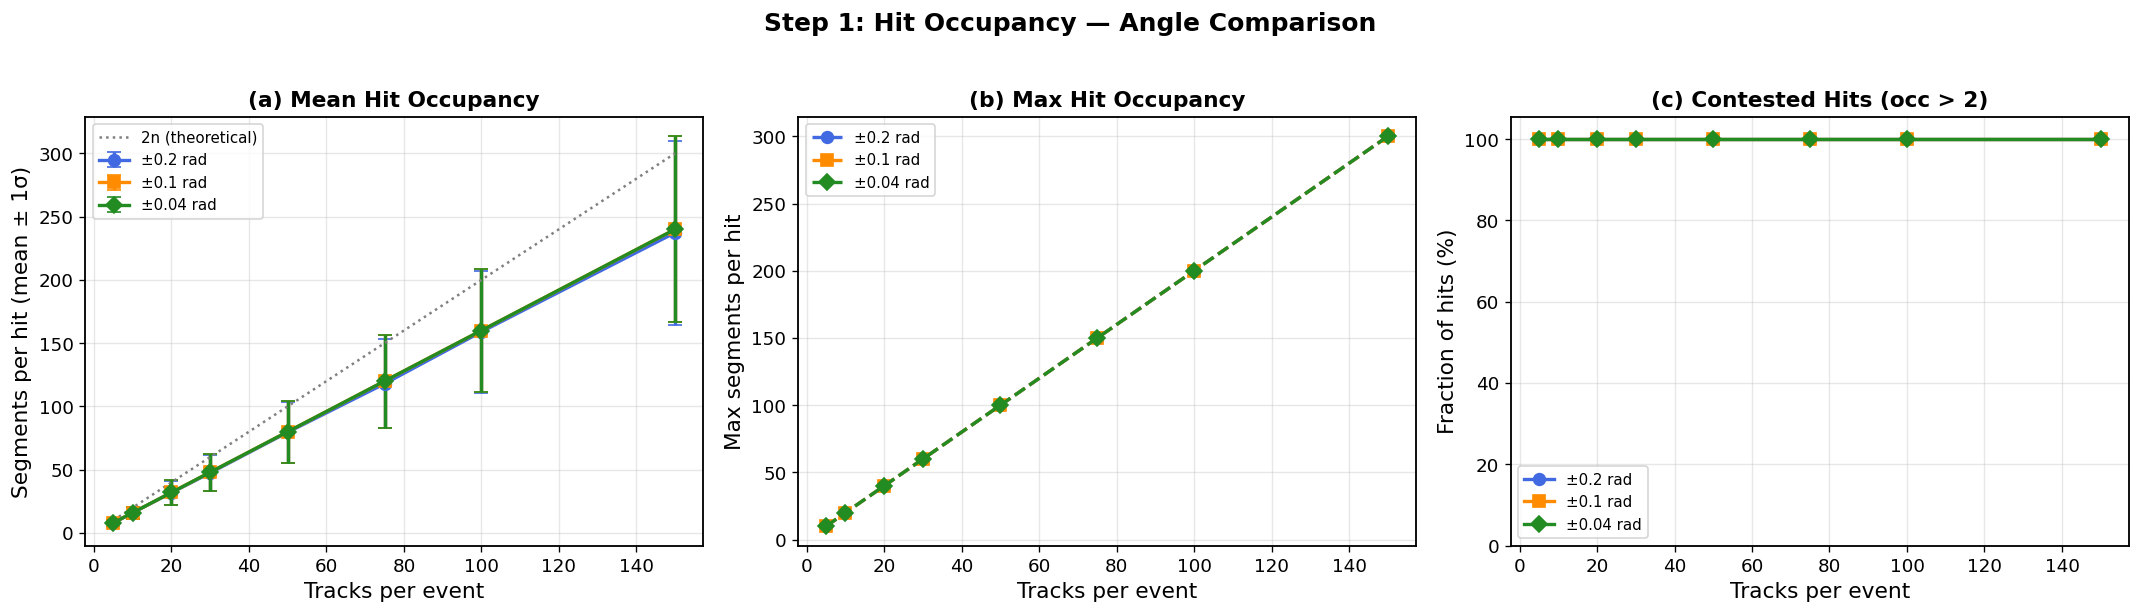

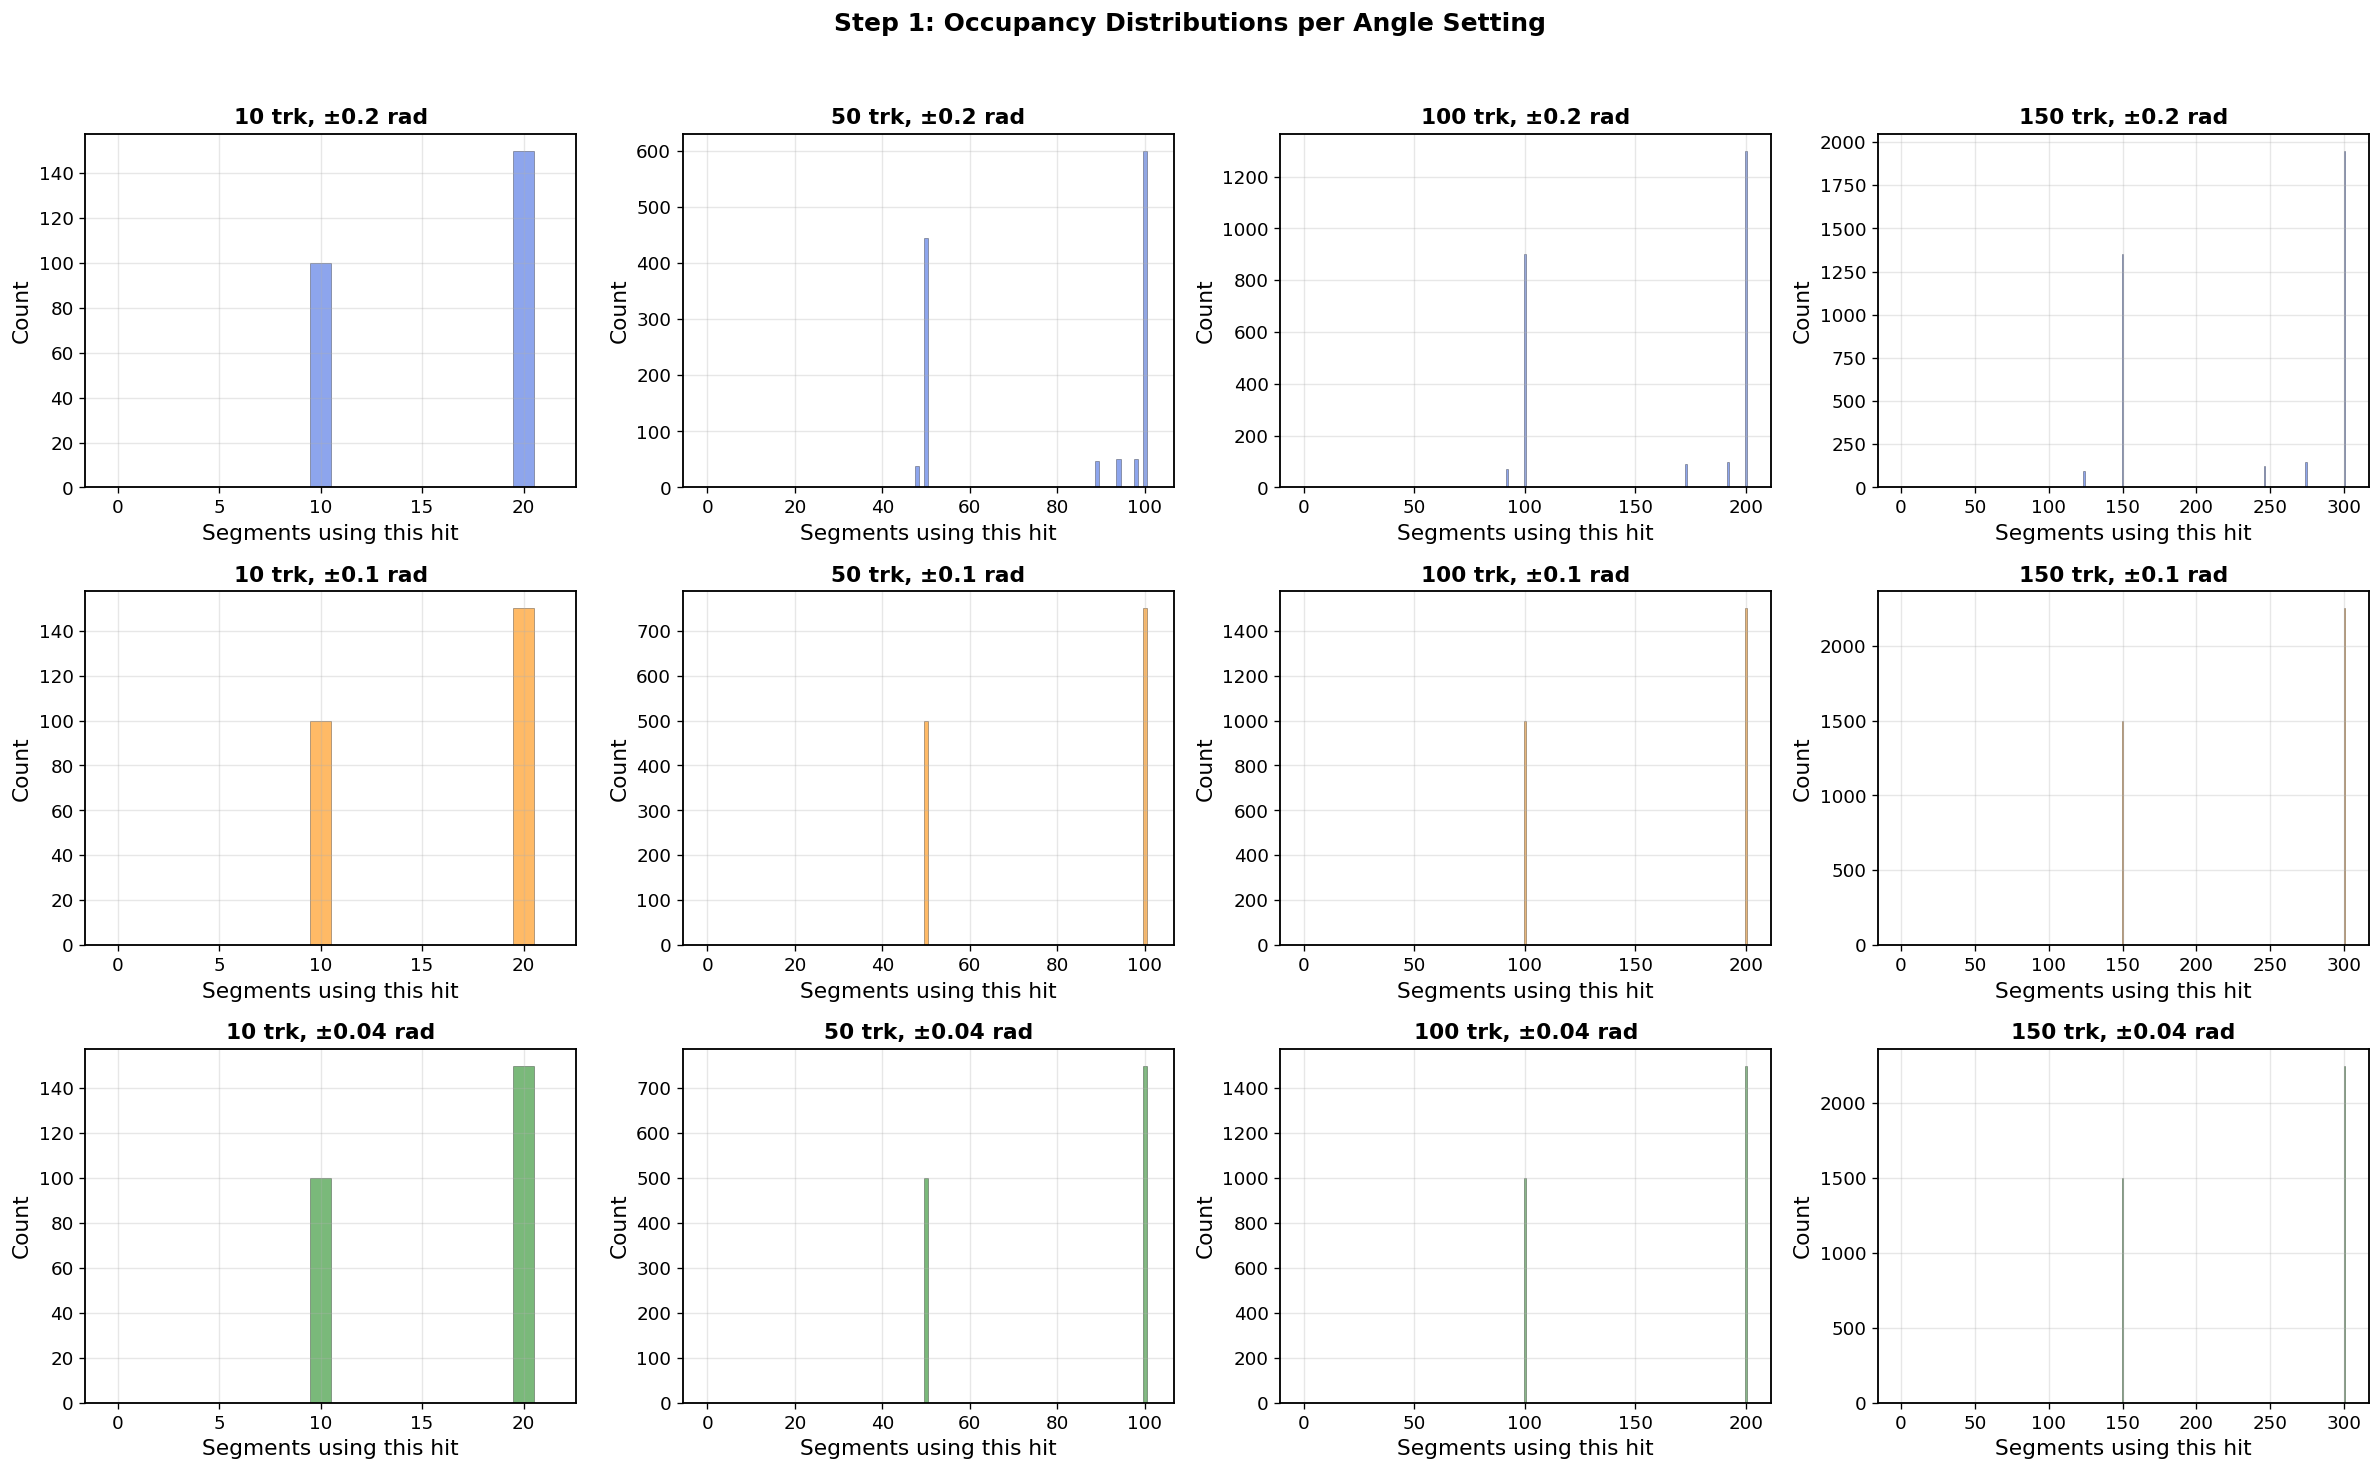

In [4]:
# ── Step 1: occupancy comparison plots across angle settings ────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x_dens = np.array(TRACK_DENSITIES)

# (a) mean occupancy vs density per angle
for angle in ANGLE_SETTINGS:
    means = np.array([occ_data[angle][n]['mean'] for n in x_dens])
    stds  = np.array([occ_data[angle][n]['std']  for n in x_dens])
    axes[0].errorbar(x_dens, means, yerr=stds,
                     fmt=f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                     capsize=4, lw=2, label=f'{ANGLE_LABELS[angle]} rad')
axes[0].plot(x_dens, 2 * x_dens, ':', color='gray', lw=1.5,
             label='2n (theoretical)')
axes[0].set_xlabel('Tracks per event')
axes[0].set_ylabel('Segments per hit (mean ± 1σ)')
axes[0].set_title('(a) Mean Hit Occupancy', fontweight='bold')
axes[0].legend(fontsize=9); axes[0].grid(True, alpha=0.3)

# (b) max occupancy vs density per angle
for angle in ANGLE_SETTINGS:
    maxes = np.array([occ_data[angle][n]['max'] for n in x_dens])
    axes[1].plot(x_dens, maxes, f'{ANGLE_MARKERS[angle]}--',
                 color=ANGLE_COLORS[angle], lw=2,
                 label=f'{ANGLE_LABELS[angle]} rad')
axes[1].set_xlabel('Tracks per event')
axes[1].set_ylabel('Max segments per hit')
axes[1].set_title('(b) Max Hit Occupancy', fontweight='bold')
axes[1].legend(fontsize=9); axes[1].grid(True, alpha=0.3)

# (c) contested fraction vs density per angle
for angle in ANGLE_SETTINGS:
    frac = [np.mean(occ_data[angle][n]['all'] > 2) * 100 for n in x_dens]
    axes[2].plot(x_dens, frac, f'{ANGLE_MARKERS[angle]}-',
                 color=ANGLE_COLORS[angle], lw=2,
                 label=f'{ANGLE_LABELS[angle]} rad')
axes[2].set_xlabel('Tracks per event')
axes[2].set_ylabel('Fraction of hits (%)')
axes[2].set_title('(c) Contested Hits (occ > 2)', fontweight='bold')
axes[2].legend(fontsize=9); axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(bottom=0)

plt.suptitle('Step 1: Hit Occupancy — Angle Comparison',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step1_occupancy_comparison")
plt.show()

# ── Occupancy histograms: rows = angles, cols = selected densities ─
sel_dens = [d for d in [10, 50, 100, 150] if d in TRACK_DENSITIES]
fig, axes = plt.subplots(len(ANGLE_SETTINGS), len(sel_dens),
                         figsize=(5 * len(sel_dens), 4 * len(ANGLE_SETTINGS)))
if len(ANGLE_SETTINGS) == 1:
    axes = [axes]

for row, angle in enumerate(ANGLE_SETTINGS):
    for col, n_trk in enumerate(sel_dens):
        ax = axes[row][col]
        arr = occ_data[angle][n_trk]['all']
        hi = int(np.max(arr)) + 2
        ax.hist(arr, bins=np.arange(0, hi + 1) - 0.5,
                alpha=0.6, color=ANGLE_COLORS[angle],
                edgecolor='black', lw=0.3)
        ax.set_xlabel('Segments using this hit')
        ax.set_ylabel('Count')
        ax.set_title(f'{n_trk} trk, {ANGLE_LABELS[angle]} rad',
                     fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.suptitle('Step 1: Occupancy Distributions per Angle Setting',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step1_occupancy_histograms")
plt.show()

---
## Step 2 — Activation Spectrum: True vs False Segments

After solving $Ax = b$, each segment $i$ gets a continuous activation
$x_i$.  True segments should be activated near or above `BASELINE`
$= \delta/(\delta+\gamma)$, while false segments should be suppressed.

At low density the distribution should be bimodal (clear separation).
The key question: **does this separation degrade at high density and
narrower generation angles?**

In [5]:
# ── Step 2: activation spectra vs density & angle ───────────────
act_data = {}  # act_data[angle][n_trk] = {'true_x', 'false_x'}

t0 = time.time()
for angle in ANGLE_SETTINGS:
    act_data[angle] = {}
    print(f"\n  Angle ±{angle}:")
    for n_trk in TRACK_DENSITIES:
        true_xs, false_xs = [], []
        for rep in range(N_REPEATS):
            event = safe_generate(geo, n_trk, phi_max=angle, theta_max=angle)
            ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
            ham.construct_hamiltonian(event)
            x = ham.solve_classicaly()
            is_true = label_segments(ham, event)
            true_xs.extend(x[is_true].tolist())
            false_xs.extend(x[~is_true].tolist())

        act_data[angle][n_trk] = {
            'true_x':  np.array(true_xs),
            'false_x': np.array(false_xs),
        }
        t_above = np.mean(np.array(true_xs) > THRESHOLD) * 100
        f_above = np.mean(np.array(false_xs) > THRESHOLD) * 100
        print(f"    {n_trk:4d} tracks: true>thr={t_above:.1f}%, "
              f"false>thr={f_above:.1f}%  "
              f"({len(true_xs)} true, {len(false_xs)} false)")

    save_json(act_data[angle], DATA_DIR / f"step2_activation_angle{angle}.json")

print(f"\nDone in {time.time()-t0:.1f}s")


  Angle ±0.2:
       5 tracks: true>thr=100.0%, false>thr=0.0%  (99 true, 396 false)
      10 tracks: true>thr=99.0%, false>thr=0.0%  (195 true, 1747 false)
      20 tracks: true>thr=100.0%, false>thr=0.0%  (396 true, 7524 false)
      30 tracks: true>thr=97.2%, false>thr=0.0%  (578 true, 16602 false)
      50 tracks: true>thr=99.8%, false>thr=0.0%  (982 true, 48082 false)
      75 tracks: true>thr=100.0%, false>thr=0.0%  (1474 true, 109076 false)
     100 tracks: true>thr=100.0%, false>thr=0.0%  (1974 true, 195426 false)
     150 tracks: true>thr=99.1%, false>thr=0.0%  (2924 true, 434428 false)

  Angle ±0.1:
       5 tracks: true>thr=100.0%, false>thr=0.0%  (100 true, 400 false)
      10 tracks: true>thr=100.0%, false>thr=0.0%  (200 true, 1800 false)
      20 tracks: true>thr=100.0%, false>thr=0.0%  (400 true, 7600 false)
      30 tracks: true>thr=100.0%, false>thr=0.0%  (600 true, 17400 false)
      50 tracks: true>thr=100.0%, false>thr=0.0%  (1000 true, 49000 false)
      75 track

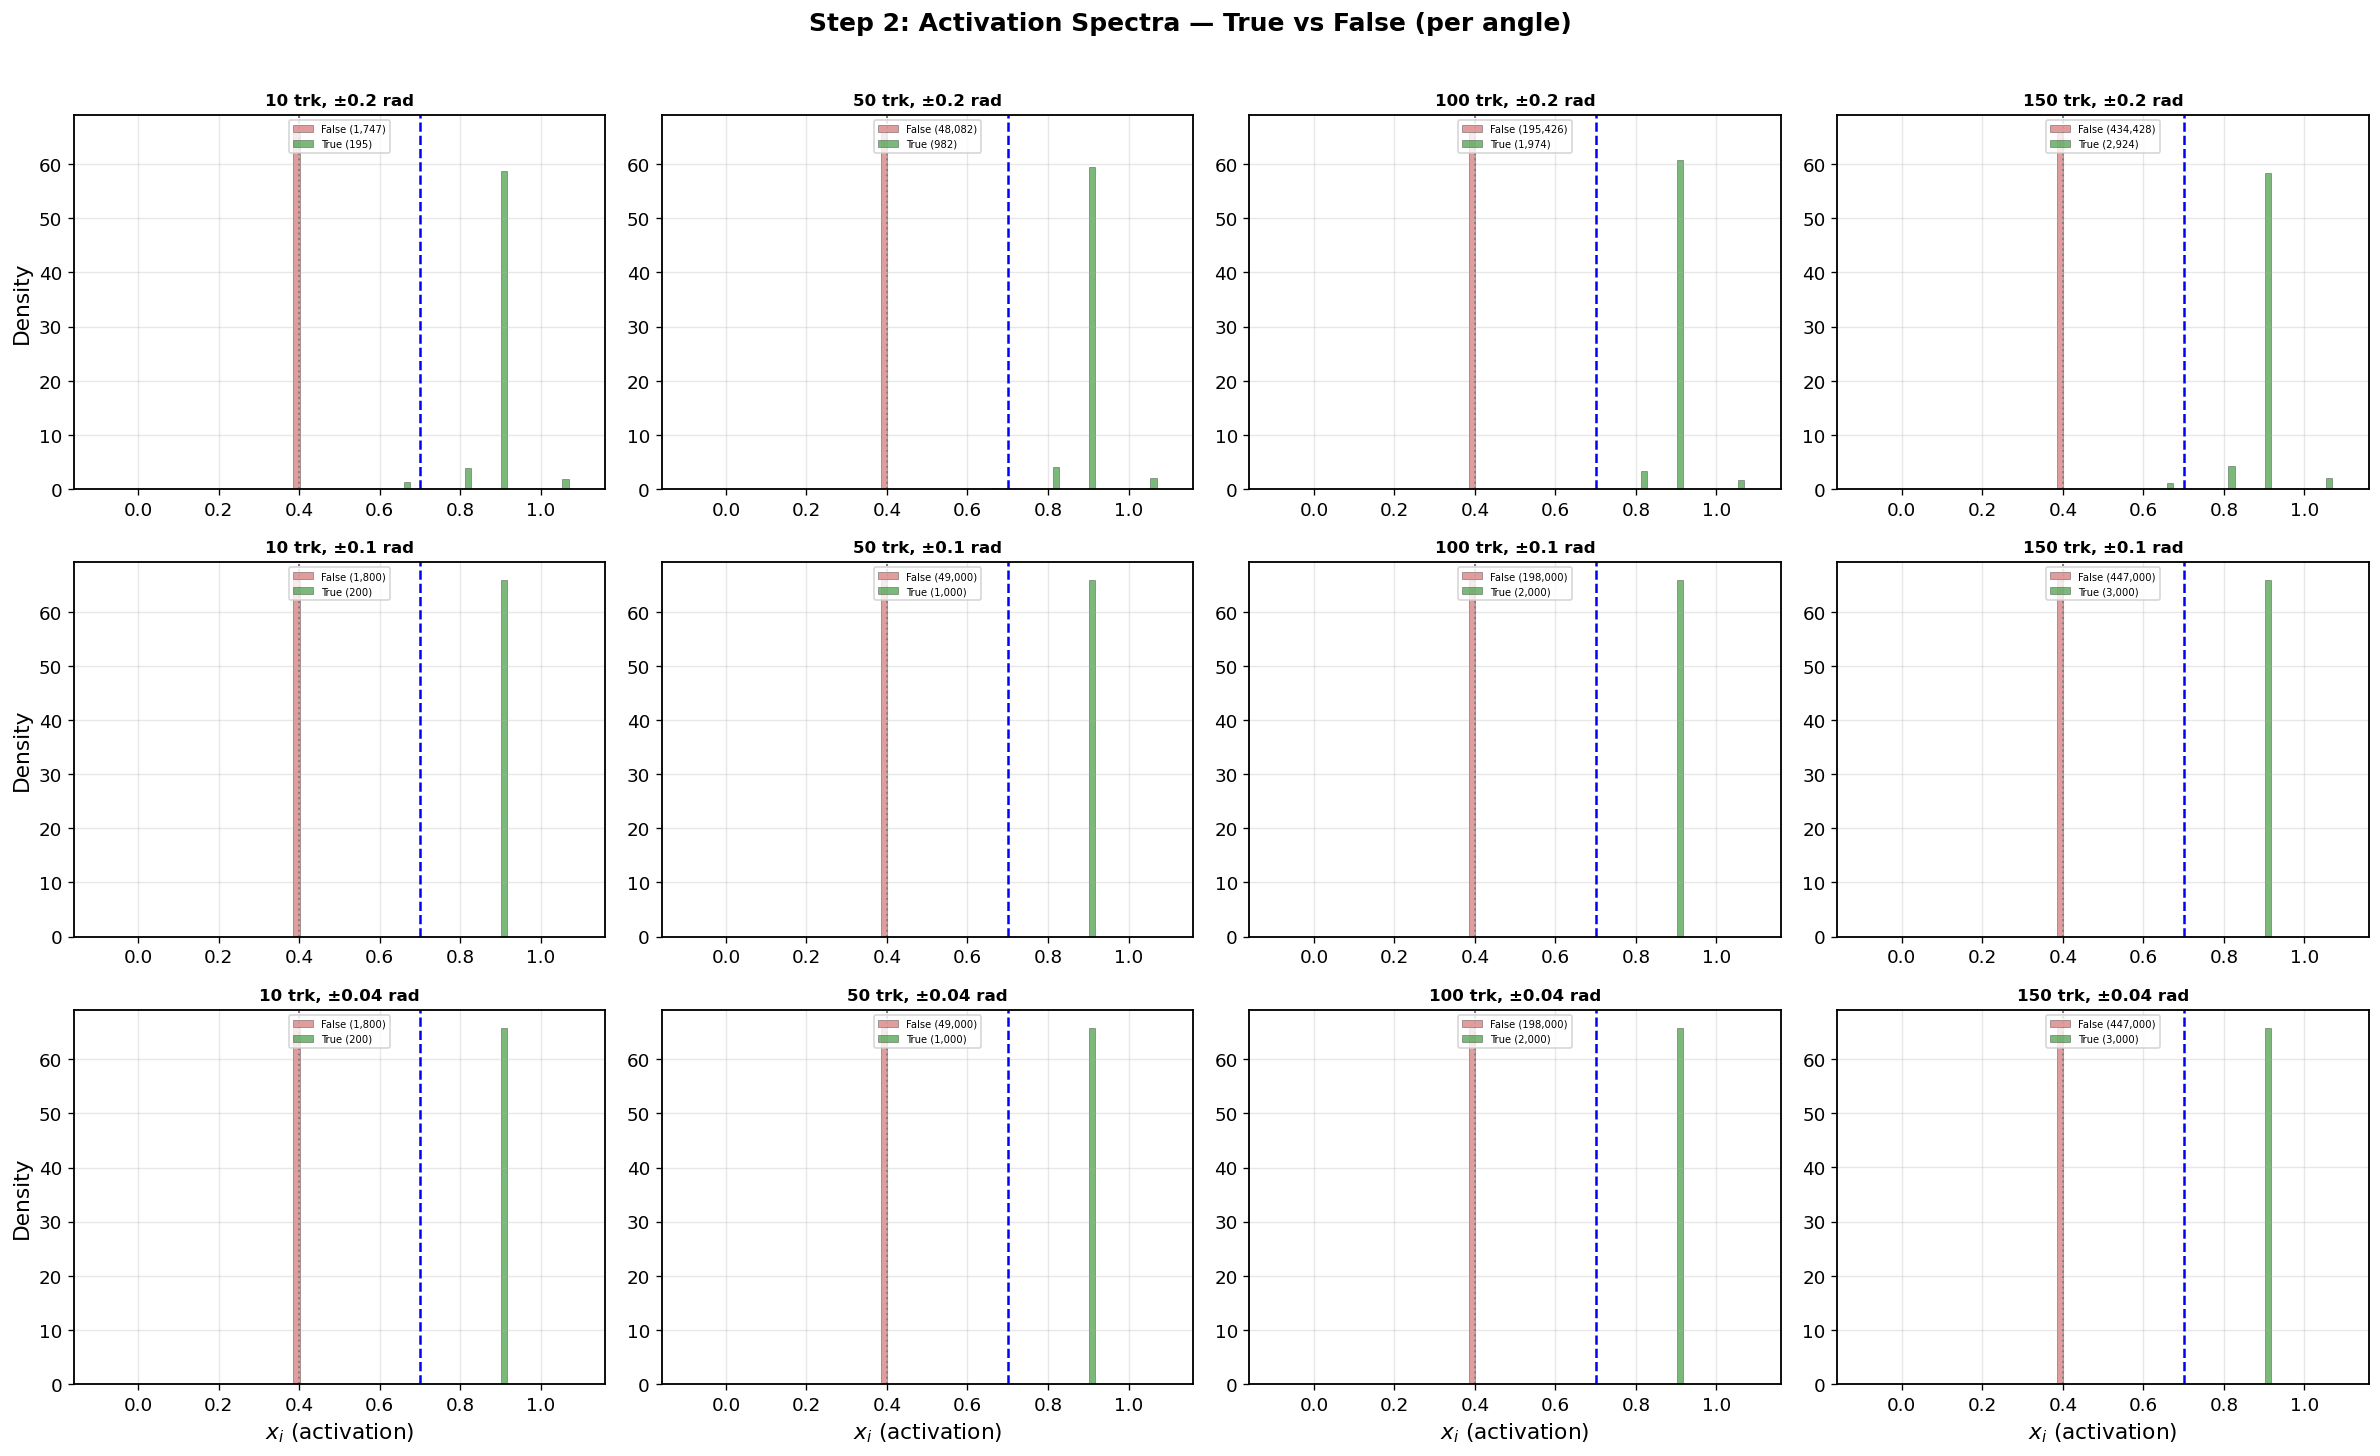

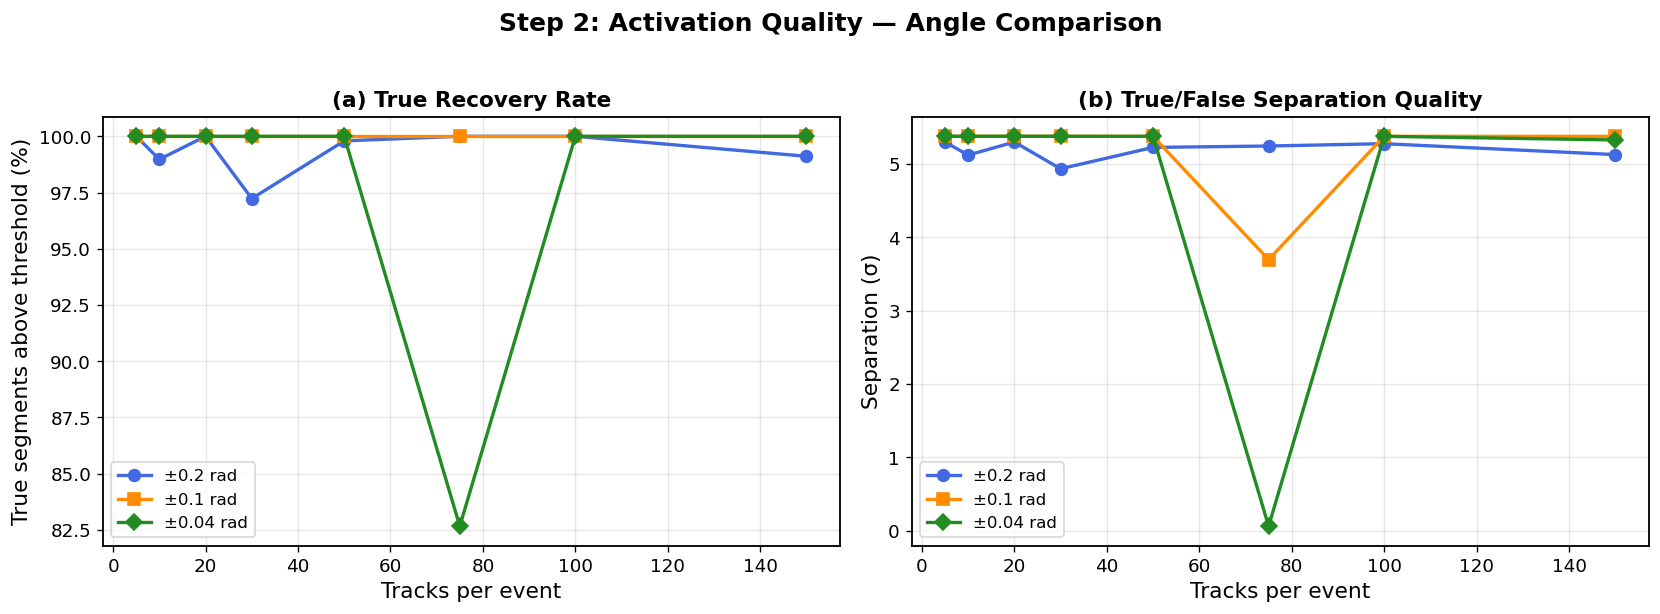

  Angle   Tracks   True mean  False mean   True>thr   False>thr   Separation
--------------------------------------------------------------------------------
   ±0.2        5      1.0852      0.4000     100.0%        0.0%         5.30σ
   ±0.2       10      1.0778      0.4000      99.0%        0.0%         5.12σ
   ±0.2       20      1.0852      0.4000     100.0%        0.0%         5.30σ
   ±0.2       30      1.0733      0.4000      97.2%        0.0%         4.93σ
   ±0.2       50      1.0808      0.4000      99.8%        0.0%         5.22σ
   ±0.2       75      1.0809      0.4000     100.0%        0.0%         5.24σ
   ±0.2      100      1.0834      0.4000     100.0%        0.0%         5.27σ
   ±0.2      150      1.0774      0.4000      99.1%        0.0%         5.12σ

   ±0.1        5      1.0909      0.4000     100.0%        0.0%         5.37σ
   ±0.1       10      1.0909      0.4000     100.0%        0.0%         5.37σ
   ±0.1       20      1.0909      0.4000     100.0%        0.

In [6]:
# ── Step 2: activation histograms — rows=angles, cols=selected densities ─
sel_dens = [d for d in [10, 50, 100, 150] if d in TRACK_DENSITIES]
fig, axes = plt.subplots(len(ANGLE_SETTINGS), len(sel_dens),
                         figsize=(5 * len(sel_dens), 4 * len(ANGLE_SETTINGS)))
if len(ANGLE_SETTINGS) == 1:
    axes = [axes]

bins = np.linspace(-0.1, 1.1, 80)
for row, angle in enumerate(ANGLE_SETTINGS):
    for col, n_trk in enumerate(sel_dens):
        ax = axes[row][col]
        tx = act_data[angle][n_trk]['true_x']
        fx = act_data[angle][n_trk]['false_x']
        ax.hist(fx, bins=bins, color='indianred', alpha=0.6, density=True,
                edgecolor='black', lw=0.3, label=f'False ({len(fx):,})')
        ax.hist(tx, bins=bins, color='forestgreen', alpha=0.6, density=True,
                edgecolor='black', lw=0.3, label=f'True ({len(tx):,})')
        ax.axvline(THRESHOLD, color='blue', ls='--', lw=1.5)
        ax.axvline(BASELINE, color='gray', ls=':', lw=1.2)
        ax.set_title(f'{n_trk} trk, {ANGLE_LABELS[angle]} rad',
                     fontweight='bold', fontsize=10)
        if col == 0:
            ax.set_ylabel('Density')
        if row == len(ANGLE_SETTINGS) - 1:
            ax.set_xlabel('$x_i$ (activation)')
        ax.legend(fontsize=6, loc='upper center')
        ax.grid(True, alpha=0.3)

plt.suptitle('Step 2: Activation Spectra — True vs False (per angle)',
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
save_fig(fig, "step2_activation_spectra")
plt.show()

# ── Summary: separation quality per angle ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for angle in ANGLE_SETTINGS:
    t_above_list, sep_list = [], []
    for n_trk in TRACK_DENSITIES:
        tx = act_data[angle][n_trk]['true_x']
        fx = act_data[angle][n_trk]['false_x']
        t_above_list.append(np.mean(tx > THRESHOLD) * 100)
        pooled = np.sqrt(0.5 * (np.var(tx) + np.var(fx)))
        sep_list.append((np.mean(tx) - np.mean(fx)) / pooled if pooled > 0 else 0)
    axes[0].plot(TRACK_DENSITIES, t_above_list,
                 f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                 lw=2, label=f'{ANGLE_LABELS[angle]} rad')
    axes[1].plot(TRACK_DENSITIES, sep_list,
                 f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                 lw=2, label=f'{ANGLE_LABELS[angle]} rad')

axes[0].set_xlabel('Tracks per event')
axes[0].set_ylabel('True segments above threshold (%)')
axes[0].set_title('(a) True Recovery Rate', fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Tracks per event')
axes[1].set_ylabel('Separation (σ)')
axes[1].set_title('(b) True/False Separation Quality', fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle('Step 2: Activation Quality — Angle Comparison',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step2_activation_summary")
plt.show()

# ── Table ──
print(f"{'Angle':>7}  {'Tracks':>7}  {'True mean':>10}  {'False mean':>10}  "
      f"{'True>thr':>9}  {'False>thr':>10}  {'Separation':>11}")
print('-' * 80)
for angle in ANGLE_SETTINGS:
    for n_trk in TRACK_DENSITIES:
        tx = act_data[angle][n_trk]['true_x']
        fx = act_data[angle][n_trk]['false_x']
        pooled = np.sqrt(0.5 * (np.var(tx) + np.var(fx)))
        sep = (np.mean(tx) - np.mean(fx)) / pooled if pooled > 0 else float('inf')
        print(f"{ANGLE_LABELS[angle]:>7}  {n_trk:7d}  {np.mean(tx):10.4f}  "
              f"{np.mean(fx):10.4f}  {np.mean(tx > THRESHOLD)*100:8.1f}%  "
              f"{np.mean(fx > THRESHOLD)*100:9.1f}%  {sep:11.2f}σ")
    print()

---
## Step 3 — Per-Hit Competition Curves

For each hit shared by multiple candidate segments, compare:
- **True segment activation**: the $x_i$ of the segment belonging to the
  correct truth track
- **False competitor load**: the sum of $x_j$ for all other (false)
  segments sharing that hit

If $\gamma$ works correctly, the true activation should remain high while
false competitors are suppressed — even at high density where many
segments share each hit.


In [ ]:
# ── Step 3: per-hit competition analysis vs density & angle ─────
comp_data = {}  # comp_data[angle][n_trk] = {'true_act', 'false_sum', 'n_competitors'}

t0 = time.time()
for angle in ANGLE_SETTINGS:
    comp_data[angle] = {}
    print(f"\n  Angle ±{angle}:")
    for n_trk in TRACK_DENSITIES:
        true_act_list, false_sum_list, n_comp_list = [], [], []

        for rep in range(N_REPEATS):
            event = safe_generate(geo, n_trk, phi_max=angle, theta_max=angle)
            ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
            ham.construct_hamiltonian(event)
            x = ham.solve_classicaly()

            is_true = label_segments(ham, event)
            h2s = build_hit_to_segments(ham)

            for hit_id, seg_indices in h2s.items():
                if len(seg_indices) < 2:
                    continue
                true_segs = [i for i in seg_indices if is_true[i]]
                false_segs = [i for i in seg_indices if not is_true[i]]
                if not true_segs or not false_segs:
                    continue
                for ts in true_segs:
                    true_act_list.append(x[ts])
                    false_sum_list.append(np.sum(x[false_segs]))
                    n_comp_list.append(len(false_segs))

        comp_data[angle][n_trk] = {
            'true_act': np.array(true_act_list),
            'false_sum': np.array(false_sum_list),
            'n_competitors': np.array(n_comp_list),
        }
        if len(true_act_list) > 0:
            print(f"    {n_trk:4d} tracks: {len(true_act_list)} contested, "
                  f"mean true_act={np.mean(true_act_list):.3f}, "
                  f"mean false_sum={np.mean(false_sum_list):.3f}, "
                  f"mean competitors={np.mean(n_comp_list):.1f}")
        else:
            print(f"    {n_trk:4d} tracks: no contested hits")

    save_json(comp_data[angle], DATA_DIR / f"step3_competition_angle{angle}.json")

print(f"\nDone in {time.time()-t0:.1f}s")


  Angle ±0.2:
       5 tracks: 198 contested, mean true_act=1.085, mean false_sum=2.788, mean competitors=7.0
      10 tracks: 380 contested, mean true_act=1.067, mean false_sum=6.168, mean competitors=15.4
      20 tracks: 760 contested, mean true_act=1.066, mean false_sum=12.925, mean competitors=32.3
      30 tracks: 1184 contested, mean true_act=1.084, mean false_sum=20.181, mean competitors=50.5
      50 tracks: 1986 contested, mean true_act=1.087, mean false_sum=34.202, mean competitors=85.5
      75 tracks: 2918 contested, mean true_act=1.077, mean false_sum=51.151, mean competitors=127.9
     100 tracks: 4000 contested, mean true_act=1.096, mean false_sum=69.306, mean competitors=173.2
     150 tracks: 5846 contested, mean true_act=1.076, mean false_sum=103.220, mean competitors=258.0

  Angle ±0.1:
       5 tracks: 200 contested, mean true_act=1.091, mean false_sum=2.800, mean competitors=7.0
      10 tracks: 400 contested, mean true_act=1.091, mean false_sum=6.300, mean comp

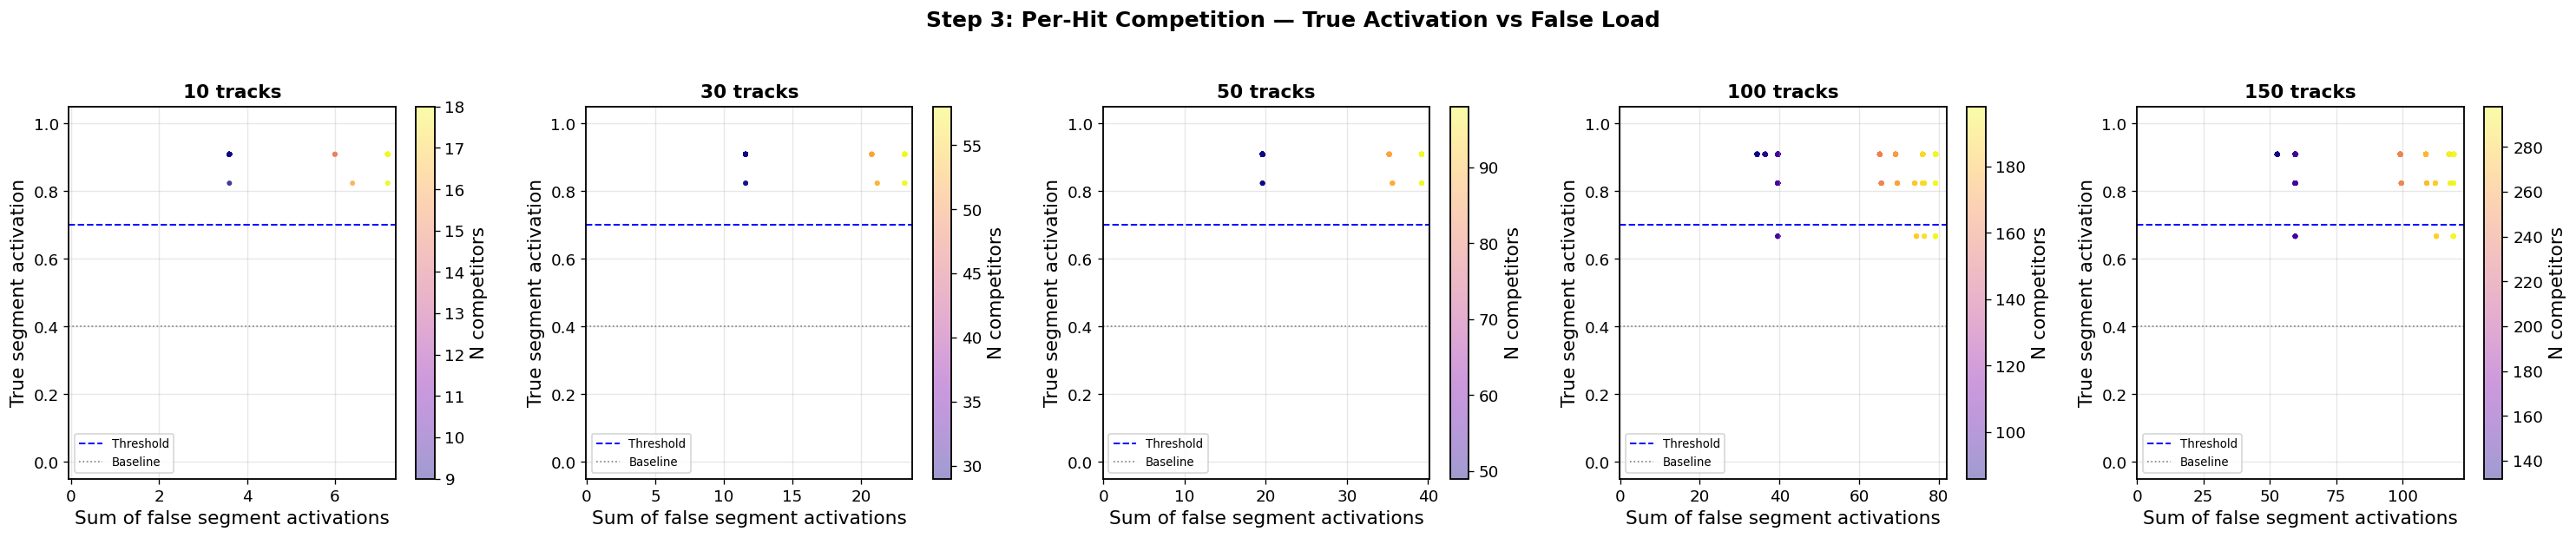

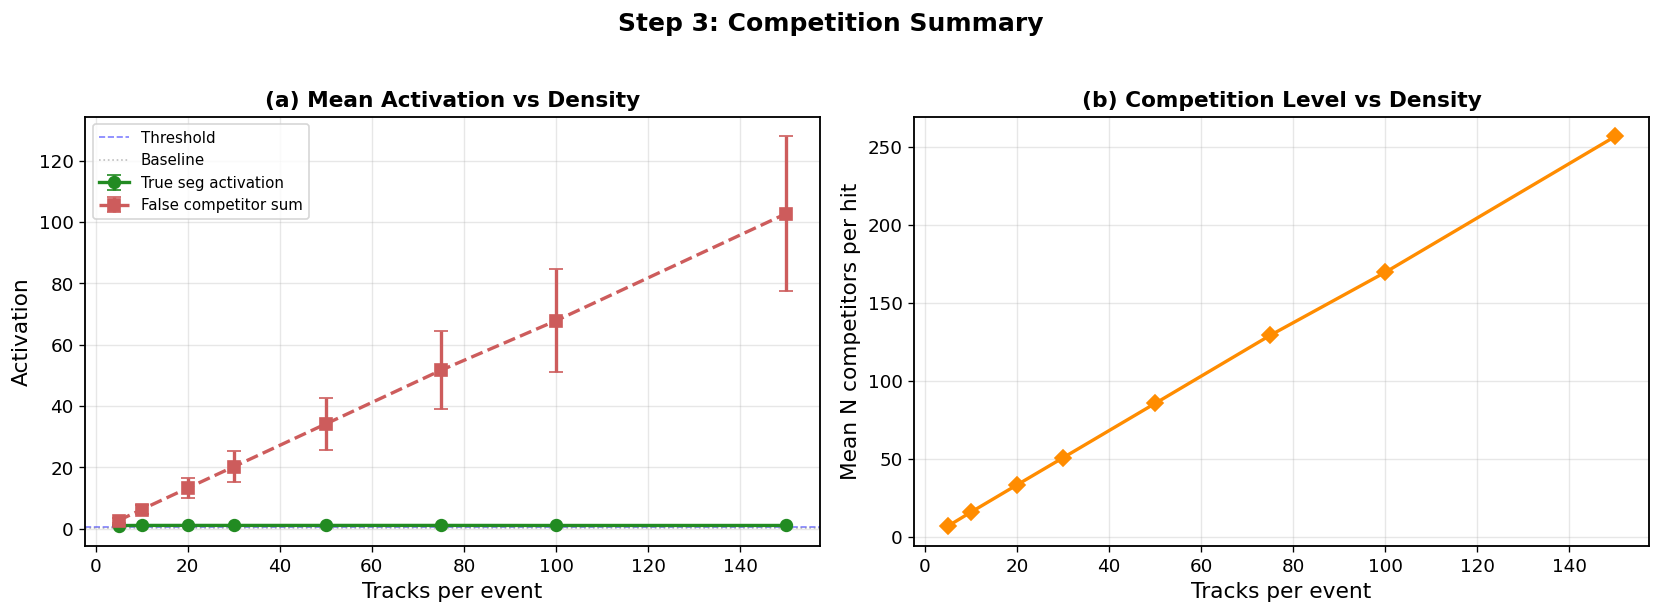

In [ ]:
# ── Step 3: competition scatter — rows=angles, cols=selected densities ──
sel = [d for d in [10, 50, 100, 150] if d in TRACK_DENSITIES]
sel = [d for d in sel
       if any(len(comp_data[a].get(d, {}).get('true_act', [])) > 0
              for a in ANGLE_SETTINGS)]

fig, axes = plt.subplots(len(ANGLE_SETTINGS), len(sel),
                         figsize=(5 * len(sel), 5 * len(ANGLE_SETTINGS)))
if len(ANGLE_SETTINGS) == 1:
    axes = [axes]
if len(sel) == 1:
    axes = [[ax] for ax in axes]

for row, angle in enumerate(ANGLE_SETTINGS):
    for col, n_trk in enumerate(sel):
        ax = axes[row][col]
        cd = comp_data[angle][n_trk]
        if len(cd['true_act']) == 0:
            ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                    ha='center', va='center')
            continue
        sc = ax.scatter(cd['false_sum'], cd['true_act'],
                        c=cd['n_competitors'], cmap='plasma',
                        s=12, alpha=0.4, edgecolors='none')
        ax.axhline(THRESHOLD, color='blue', ls='--', lw=1.2, label='Threshold')
        ax.axhline(BASELINE, color='gray', ls=':', lw=1, label='Baseline')
        ax.set_xlabel('Sum of false segment activations')
        ax.set_ylabel('True segment activation')
        ax.set_title(f'{n_trk} trk, {ANGLE_LABELS[angle]} rad',
                     fontweight='bold')
        ax.set_xlim(left=-0.05); ax.set_ylim(-0.05, 1.05)
        ax.legend(fontsize=7, loc='lower left')
        ax.grid(True, alpha=0.3)
        plt.colorbar(sc, ax=ax, label='N competitors')

plt.suptitle('Step 3: Per-Hit Competition — True Activation vs False Load',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step3_competition_scatter")
plt.show()

# ── Summary: mean true activation & false sum vs density per angle ──
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for angle in ANGLE_SETTINGS:
    x_dens = np.array([n for n in TRACK_DENSITIES
                        if len(comp_data[angle].get(n, {}).get('true_act', [])) > 0])
    if len(x_dens) == 0:
        continue
    mt = [np.mean(comp_data[angle][n]['true_act']) for n in x_dens]
    st = [np.std(comp_data[angle][n]['true_act'])  for n in x_dens]
    mf = [np.mean(comp_data[angle][n]['false_sum']) for n in x_dens]
    mc = [np.mean(comp_data[angle][n]['n_competitors']) for n in x_dens]

    axes[0].errorbar(x_dens, mt, yerr=st,
                     fmt=f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                     capsize=4, lw=2, label=f'{ANGLE_LABELS[angle]} rad')
    axes[1].plot(x_dens, mf, f'{ANGLE_MARKERS[angle]}-',
                 color=ANGLE_COLORS[angle], lw=2,
                 label=f'{ANGLE_LABELS[angle]} rad')
    axes[2].plot(x_dens, mc, f'{ANGLE_MARKERS[angle]}-',
                 color=ANGLE_COLORS[angle], lw=2,
                 label=f'{ANGLE_LABELS[angle]} rad')

axes[0].axhline(THRESHOLD, color='blue', ls='--', lw=1, alpha=0.5)
axes[0].axhline(BASELINE, color='gray', ls=':', lw=1, alpha=0.5)
axes[0].set_xlabel('Tracks per event')
axes[0].set_ylabel('True segment activation')
axes[0].set_title('(a) Mean True Activation', fontweight='bold')
axes[0].legend(fontsize=9); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Tracks per event')
axes[1].set_ylabel('Mean false competitor sum')
axes[1].set_title('(b) False Competitor Load', fontweight='bold')
axes[1].legend(fontsize=9); axes[1].grid(True, alpha=0.3)

axes[2].set_xlabel('Tracks per event')
axes[2].set_ylabel('Mean N competitors per contested hit')
axes[2].set_title('(c) Competition Level', fontweight='bold')
axes[2].legend(fontsize=9); axes[2].grid(True, alpha=0.3)

plt.suptitle('Step 3: Competition Summary — Angle Comparison',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step3_competition_summary")
plt.show()

---
## Step 4 — Track-Level Reconstruction Quality vs Density

End-to-end test: `generate` → `Hamiltonian` → `solve` → `get_tracks`
→ `EventValidator`.  Plot efficiency, ghost rate, and clone rate across
the full density range.  This is the bottom-line test of whether the
Hamiltonian inversion resolves ambiguities at high density.


In [ ]:
# ── Step 4: track-level reconstruction sweep per angle ──────────
reco_results = []  # list of dicts with 'angle' key

t0 = time.time()
for angle in ANGLE_SETTINGS:
    print(f"\n  Angle ±{angle}:")
    for n_trk in TRACK_DENSITIES:
        for rep in range(N_REPEATS):
            event = safe_generate(geo, n_trk, phi_max=angle, theta_max=angle)
            ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
            ham.construct_hamiltonian(event)
            x = ham.solve_classicaly()
            reco = get_tracks(ham, x, event, threshold=THRESHOLD)
            val = EventValidator(event, reco)
            matches, metrics = val.match_tracks(purity_min=0.7)

            reco_hit_ids = {hid for trk in reco for hid in trk.hit_ids}
            reco_hits = [h for h in event.hits if h.hit_id in reco_hit_ids]
            reco_event = construct_event(geo, reco, reco_hits)
            tag = f"step4_a{angle}_n{n_trk}_r{rep}"
            event.to_json(str(EVENT_DIR / f"{tag}_truth.json"))
            reco_event.to_json(str(EVENT_DIR / f"{tag}_reco.json"))

            reco_results.append({
                'angle': angle,
                'n_tracks': n_trk,
                'repeat': rep,
                'efficiency': metrics['efficiency'],
                'ghost_rate': metrics['ghost_rate'],
                'clone_fraction': metrics.get('clone_fraction', 0.0),
                'n_reco': len(reco),
                'n_truth': len(event.tracks),
                'n_segments': ham.n_segments,
            })

        eff = np.mean([r['efficiency'] for r in reco_results
                       if r['n_tracks'] == n_trk and r['angle'] == angle])
        gr  = np.mean([r['ghost_rate'] for r in reco_results
                       if r['n_tracks'] == n_trk and r['angle'] == angle])
        print(f"    {n_trk:4d} tracks: eff={eff:.3f}, ghost={gr:.3f}")

    save_json(reco_results, DATA_DIR / "step4_reco_results.json")

print(f"\nDone in {time.time()-t0:.1f}s")

     5 tracks: eff=1.000, ghost=0.000
    10 tracks: eff=0.960, ghost=0.000
    20 tracks: eff=0.970, ghost=0.000
    30 tracks: eff=1.000, ghost=0.000
    50 tracks: eff=1.000, ghost=0.000
    75 tracks: eff=1.000, ghost=0.000
   100 tracks: eff=1.000, ghost=0.000
   150 tracks: eff=0.960, ghost=0.000

Done in 1871.2s


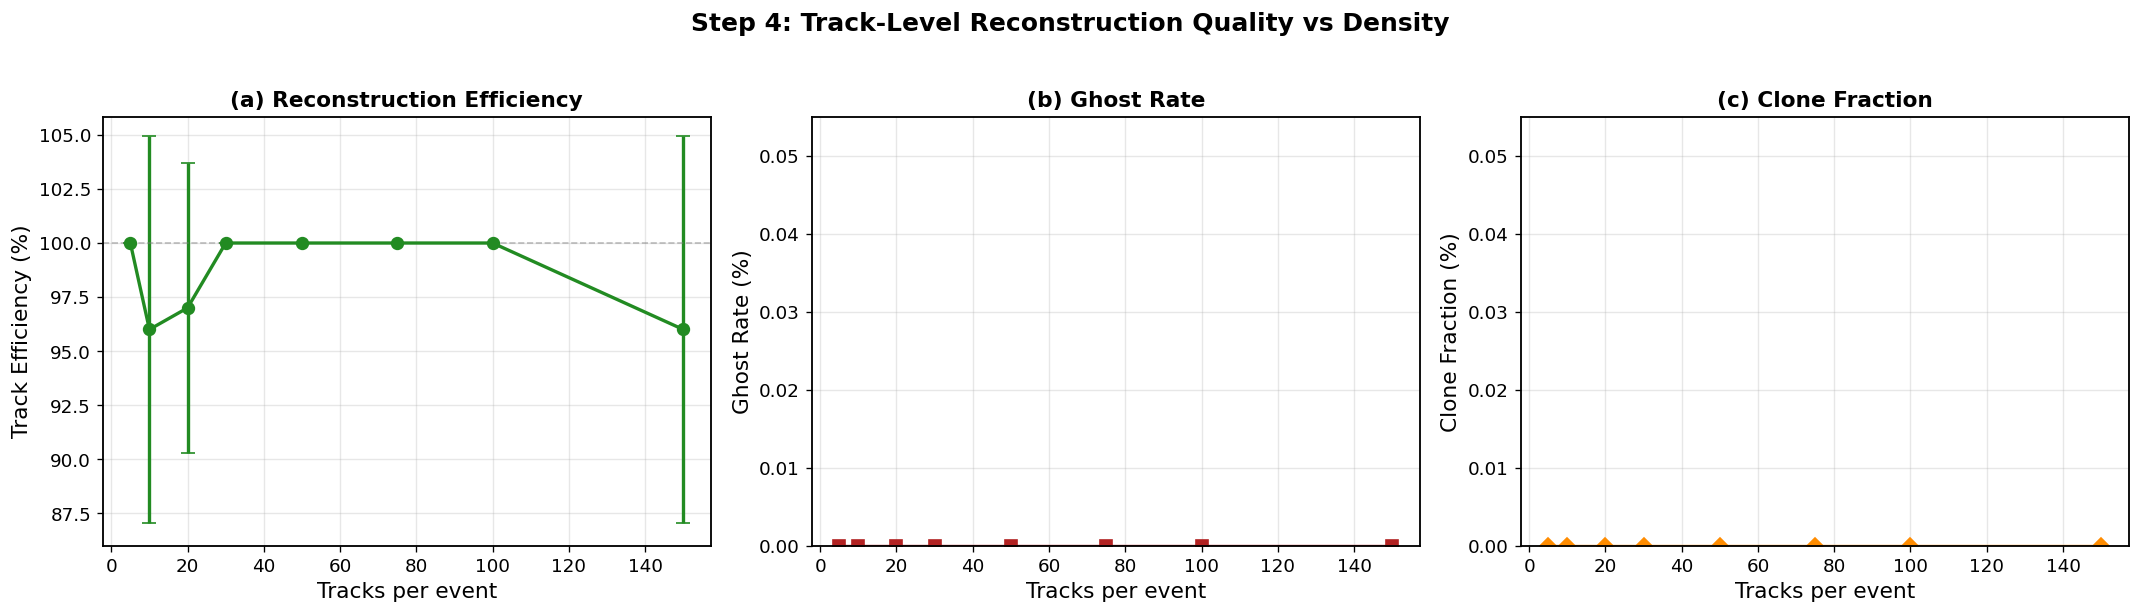

 Tracks     Eff (%)   Ghost (%)   Clone (%)    N reco    N segs
-----------------------------------------------------------------
      5    100.0±0.0      0.0±0.0      0.0±0.0         5       100
     10     96.0±8.9      0.0±0.0      0.0±0.0        10       380
     20     97.0±6.7      0.0±0.0      0.0±0.0        19      1552
     30    100.0±0.0      0.0±0.0      0.0±0.0        30      3600
     50    100.0±0.0      0.0±0.0      0.0±0.0        50      9900
     75    100.0±0.0      0.0±0.0      0.0±0.0        75     21945
    100    100.0±0.0      0.0±0.0      0.0±0.0       100     40000
    150     96.0±8.9      0.0±0.0      0.0±0.0       144     86190


In [ ]:
# ── Step 4: track-level plots per angle ──────────────────────────
import pandas as pd

df = pd.DataFrame(reco_results)
save_json(df.to_dict(orient="list"), DATA_DIR / "step4_reco_results_table.json")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for angle in ANGLE_SETTINGS:
    sub = df[df['angle'] == angle]
    agg = sub.groupby('n_tracks').agg(
        eff_mean=('efficiency', 'mean'), eff_std=('efficiency', 'std'),
        gr_mean=('ghost_rate', 'mean'), gr_std=('ghost_rate', 'std'),
        clone_mean=('clone_fraction', 'mean'), clone_std=('clone_fraction', 'std'),
    ).reset_index()

    axes[0].errorbar(agg['n_tracks'], agg['eff_mean'] * 100,
                     yerr=agg['eff_std'] * 100,
                     fmt=f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                     capsize=4, lw=2, label=f'{ANGLE_LABELS[angle]} rad')
    axes[1].errorbar(agg['n_tracks'], agg['gr_mean'] * 100,
                     yerr=agg['gr_std'] * 100,
                     fmt=f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                     capsize=4, lw=2, label=f'{ANGLE_LABELS[angle]} rad')
    axes[2].errorbar(agg['n_tracks'], agg['clone_mean'] * 100,
                     yerr=agg['clone_std'] * 100,
                     fmt=f'{ANGLE_MARKERS[angle]}-', color=ANGLE_COLORS[angle],
                     capsize=4, lw=2, label=f'{ANGLE_LABELS[angle]} rad')

axes[0].axhline(100, color='gray', ls='--', lw=1, alpha=0.5)
axes[0].set_xlabel('Tracks per event')
axes[0].set_ylabel('Efficiency (%)')
axes[0].set_title('(a) Reconstruction Efficiency', fontweight='bold')
axes[0].legend(fontsize=9); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Tracks per event')
axes[1].set_ylabel('Ghost Rate (%)')
axes[1].set_title('(b) Ghost Rate', fontweight='bold')
axes[1].set_ylim(bottom=0)
axes[1].legend(fontsize=9); axes[1].grid(True, alpha=0.3)

axes[2].set_xlabel('Tracks per event')
axes[2].set_ylabel('Clone Fraction (%)')
axes[2].set_title('(c) Clone Fraction', fontweight='bold')
axes[2].set_ylim(bottom=0)
axes[2].legend(fontsize=9); axes[2].grid(True, alpha=0.3)

plt.suptitle('Step 4: Track-Level Quality — Angle Comparison',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step4_reco_quality")
plt.show()

# ── Summary table ──
print(f"{'Angle':>7}  {'Tracks':>7}  {'Eff (%)':>10}  {'Ghost (%)':>10}  "
      f"{'Clone (%)':>10}")
print('-' * 55)
for angle in ANGLE_SETTINGS:
    sub = df[df['angle'] == angle]
    agg = sub.groupby('n_tracks').agg(
        eff_mean=('efficiency', 'mean'), eff_std=('efficiency', 'std'),
        gr_mean=('ghost_rate', 'mean'), gr_std=('ghost_rate', 'std'),
        clone_mean=('clone_fraction', 'mean'), clone_std=('clone_fraction', 'std'),
    ).reset_index()
    for _, row in agg.iterrows():
        print(f"{ANGLE_LABELS[angle]:>7}  {int(row.n_tracks):7d}  "
              f"{row.eff_mean*100:7.1f}±{row.eff_std*100:.1f}  "
              f"{row.gr_mean*100:7.1f}±{row.gr_std*100:.1f}  "
              f"{row.clone_mean*100:7.1f}±{row.clone_std*100:.1f}")
    print()

---
## Step 5 — Threshold Sensitivity / ROC Curves

Vary the activation threshold from 0.2 to 0.9 and plot efficiency vs
ghost rate at several track densities.  This reveals how much headroom
the Hamiltonian provides for the threshold choice, and whether high
density narrows the operating window.


In [ ]:
# ── Step 5: threshold sweep → ROC-like curves per angle ─────────
THRESHOLDS = np.linspace(0.2, 0.9, 15)
ROC_DENSITIES = [10, 30, 50, 100, 150]
ROC_REPEATS = 5

roc_data = {}  # roc_data[angle][n_trk] = {'thresholds', 'eff', 'ghost'}

t0 = time.time()
for angle in ANGLE_SETTINGS:
    roc_data[angle] = {}
    print(f"\n  Angle ±{angle}:")
    for n_trk in ROC_DENSITIES:
        solved_events = []
        for rep in range(ROC_REPEATS):
            event = safe_generate(geo, n_trk, phi_max=angle, theta_max=angle)
            ham = SimpleHamiltonianFast(epsilon=EPSILON, gamma=GAMMA, delta=DELTA)
            ham.construct_hamiltonian(event)
            x = ham.solve_classicaly()
            solved_events.append((event, ham, x))
            tag = f"step5_a{angle}_n{n_trk}_r{rep}"
            event.to_json(str(EVENT_DIR / f"{tag}_truth.json"))

        eff_by_thr, ghost_by_thr = [], []
        for thr in THRESHOLDS:
            effs, ghosts = [], []
            for event, ham, x in solved_events:
                reco = get_tracks(ham, x, event, threshold=thr)
                if len(reco) == 0:
                    effs.append(0.0); ghosts.append(0.0)
                    continue
                val = EventValidator(event, reco)
                _, metrics = val.match_tracks(purity_min=0.7)
                effs.append(metrics['efficiency'])
                ghosts.append(metrics['ghost_rate'])
            eff_by_thr.append(np.mean(effs))
            ghost_by_thr.append(np.mean(ghosts))

        roc_data[angle][n_trk] = {
            'thresholds': THRESHOLDS,
            'eff': np.array(eff_by_thr),
            'ghost': np.array(ghost_by_thr),
        }
        print(f"    {n_trk:4d} tracks — done")

    save_json(roc_data[angle], DATA_DIR / f"step5_roc_angle{angle}.json")

print(f"\nDone in {time.time()-t0:.1f}s")

    10 tracks — done


RecursionError: maximum recursion depth exceeded

In [ ]:
# ── Step 5: ROC plots — one panel per angle ─────────────────────
fig, axes = plt.subplots(1, len(ANGLE_SETTINGS), figsize=(6 * len(ANGLE_SETTINGS), 5))
if len(ANGLE_SETTINGS) == 1:
    axes = [axes]

dens_colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(ROC_DENSITIES)))

for a_idx, angle in enumerate(ANGLE_SETTINGS):
    ax = axes[a_idx]
    for d_idx, n_trk in enumerate(ROC_DENSITIES):
        rd = roc_data[angle][n_trk]
        ax.plot(rd['ghost'] * 100, rd['eff'] * 100,
                'o-', color=dens_colors[d_idx], lw=2, markersize=4,
                label=f'{n_trk} tracks')
        idx_def = np.argmin(np.abs(rd['thresholds'] - THRESHOLD))
        ax.plot(rd['ghost'][idx_def] * 100, rd['eff'][idx_def] * 100,
                '*', color=dens_colors[d_idx], markersize=14,
                markeredgecolor='black', markeredgewidth=0.8)
    ax.set_xlabel('Ghost Rate (%)')
    ax.set_ylabel('Efficiency (%)')
    ax.set_title(f'ROC — {ANGLE_LABELS[angle]} rad\n(★ = default thr)',
                 fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Step 5: Threshold Sensitivity / ROC — Angle Comparison',
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
save_fig(fig, "step5_roc_by_angle")
plt.show()

# ── Efficiency & Ghost vs Threshold per angle ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for angle in ANGLE_SETTINGS:
    for d_idx, n_trk in enumerate(ROC_DENSITIES):
        rd = roc_data[angle][n_trk]
        ls = '-' if angle == 0.2 else ('--' if angle == 0.1 else ':')
        axes[0].plot(rd['thresholds'], rd['eff'] * 100,
                     ls, color=dens_colors[d_idx], lw=1.5, alpha=0.7,
                     label=f'{n_trk}trk {ANGLE_LABELS[angle]}' if d_idx == 0 or n_trk == ROC_DENSITIES[0] else None)
        axes[1].plot(rd['thresholds'], rd['ghost'] * 100,
                     ls, color=dens_colors[d_idx], lw=1.5, alpha=0.7)

axes[0].axvline(THRESHOLD, color='blue', ls='--', lw=1.2, alpha=0.6)
axes[0].set_xlabel('Threshold'); axes[0].set_ylabel('Efficiency (%)')
axes[0].set_title('(a) Efficiency vs Threshold', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].axvline(THRESHOLD, color='blue', ls='--', lw=1.2, alpha=0.6)
axes[1].set_xlabel('Threshold'); axes[1].set_ylabel('Ghost Rate (%)')
axes[1].set_title('(b) Ghost Rate vs Threshold', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Custom legend: solid=±0.2, dashed=±0.1, dotted=±0.04
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], ls='-', color='black', label='±0.2 rad'),
                   Line2D([0], [0], ls='--', color='black', label='±0.1 rad'),
                   Line2D([0], [0], ls=':', color='black', label='±0.04 rad')]
axes[0].legend(handles=legend_elements, fontsize=9)
axes[1].legend(handles=legend_elements, fontsize=9)

plt.suptitle('Step 5: Threshold Curves — Angle Comparison',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step5_threshold_curves")
plt.show()

# ── Optimal threshold per angle/density ──
print(f"\n{'Angle':>7}  {'Tracks':>7}  {'Opt Thr':>8}  {'Eff (%)':>8}  {'Ghost (%)':>9}")
print('-' * 48)
for angle in ANGLE_SETTINGS:
    for n_trk in ROC_DENSITIES:
        rd = roc_data[angle][n_trk]
        mask = rd['ghost'] < 0.20
        if mask.any():
            best_idx = np.argmax(rd['eff'][mask])
            best_thr = rd['thresholds'][mask][best_idx]
            best_eff = rd['eff'][mask][best_idx]
            best_gr  = rd['ghost'][mask][best_idx]
        else:
            best_idx = np.argmax(rd['eff'])
            best_thr = rd['thresholds'][best_idx]
            best_eff = rd['eff'][best_idx]
            best_gr  = rd['ghost'][best_idx]
        print(f"{ANGLE_LABELS[angle]:>7}  {n_trk:7d}  {best_thr:8.3f}  "
              f"{best_eff*100:7.1f}  {best_gr*100:8.1f}")
    print()

---
## Step 6 — Segment-Level Metrics vs Event Size: Scattering Comparison

Sweep track counts from 10 to 100 (step 10), 5 repeats per size.
Compare three scattering settings: 1×, 2×, 4× baseline ($\sigma_\mathrm{scatt}$ = 1e-4, 2e-4, 4e-4 rad).
Metrics: segment efficiency, false rate, pair counts, accepted pair counts.

This mirrors the scattering comparison in the characterisation notebook, but
also crosses it with the generation angle settings from previous steps.

In [ ]:
# ── Step 6: scattering comparison — segment metrics vs event size ──
TRACK_SIZES_SCATT = list(range(10, 110, 10))
N_REPEATS_SCATT   = 5
SCATT_MULTIPLIERS = [1, 2, 4]          # 1×, 2×, 4× baseline scattering
SIGMA_SCATT_BASE  = SIGMA_SCATT        # 1e-4 rad from parameters cell

# Compute epsilon per scattering multiplier
all_epsilons = {}
for mult in SCATT_MULTIPLIERS:
    sigma_s = SIGMA_SCATT_BASE * mult
    all_epsilons[mult] = compute_epsilon(SIGMA_RES, sigma_s, DZ_MM, scale=SCALE)

# Store results keyed by multiplier
all_scan_results = {}   # {mult: [list of per-size dicts]}

t0_all = time.time()

for mult in SCATT_MULTIPLIERS:
    sigma_s = SIGMA_SCATT_BASE * mult
    eps = all_epsilons[mult]
    print(f"\n{'='*60}")
    print(f"  Scattering {mult}x:  sigma_scatt = {sigma_s:.1e} rad")
    print(f"  epsilon = {eps:.6f} rad  ({eps*1e3:.3f} mrad)")
    print(f"{'='*60}")

    scan_results_m = []
    t0 = time.time()

    for n_trk in TRACK_SIZES_SCATT:
        per_repeat = []
        for rep in range(N_REPEATS_SCATT):
            event = safe_generate(geo, n_trk, collision_noise=sigma_s)
            true_angles, false_angles = collect_segment_pair_angles(event)
            ta = np.array(true_angles)
            fa = np.array(false_angles)
            t_acc = int(np.sum(ta <= eps))
            f_acc = int(np.sum(fa <= eps))
            tot = t_acc + f_acc
            per_repeat.append({
                'n_true': len(ta), 'n_false': len(fa),
                'true_acc': t_acc,  'false_acc': f_acc,
                'eff': t_acc / len(ta) if len(ta) else 0,
                'fr':  f_acc / tot     if tot     else 0,
            })

        effs = np.array([r['eff'] for r in per_repeat])
        frs  = np.array([r['fr']  for r in per_repeat])
        se = lambda a: np.std(a, ddof=1) / np.sqrt(len(a)) if len(a) > 1 else 0.0
        scan_results_m.append({
            'n_tracks':     n_trk,
            'eff_mean':     np.mean(effs) * 100,
            'eff_se':       se(effs) * 100,
            'fr_mean':      np.mean(frs) * 100,
            'fr_se':        se(frs) * 100,
            'n_true_mean':  np.mean([r['n_true']  for r in per_repeat]),
            'n_true_se':    se(np.array([r['n_true']  for r in per_repeat], dtype=float)),
            'n_false_mean': np.mean([r['n_false'] for r in per_repeat]),
            'n_false_se':   se(np.array([r['n_false'] for r in per_repeat], dtype=float)),
            'true_acc_mean':  np.mean([r['true_acc']  for r in per_repeat]),
            'true_acc_se':    se(np.array([r['true_acc']  for r in per_repeat], dtype=float)),
            'false_acc_mean': np.mean([r['false_acc'] for r in per_repeat]),
            'false_acc_se':   se(np.array([r['false_acc'] for r in per_repeat], dtype=float)),
        })
        print(f'  {n_trk:3d} tracks  eff {scan_results_m[-1]["eff_mean"]:.1f}%  '
              f'FR {scan_results_m[-1]["fr_mean"]:.2f}%  [{time.time()-t0:.1f}s]')

    all_scan_results[mult] = scan_results_m

save_json(all_scan_results, DATA_DIR / "step6_scattering_scan.json")
save_json({str(k): v for k, v in all_epsilons.items()},
          DATA_DIR / "step6_epsilons.json")

print(f'\nAll scans done in {time.time()-t0_all:.1f}s')
for mult in SCATT_MULTIPLIERS:
    eps = all_epsilons[mult]
    print(f'  {mult}x scattering: epsilon = {eps*1e3:.3f} mrad')

In [ ]:
# ── Step 6: scattering comparison — plots ────────────────────────
# One colour per scattering multiplier
scatter_colors = {1: '#1b7837', 2: '#2166ac', 4: '#c51b7d'}
scatter_fmts   = {1: 'o-',     2: 's--',     4: 'D:'}

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

for mult in SCATT_MULTIPLIERS:
    results = all_scan_results[mult]
    eps = all_epsilons[mult]
    col = scatter_colors[mult]
    fmt = scatter_fmts[mult]
    lbl = f'{mult}x ($\\varepsilon$={eps*1e3:.2f} mrad)'

    x_tracks = np.array([r['n_tracks'] for r in results])

    # ── (a) Segment Efficiency ──
    ax = axes[0, 0]
    eff_mean = np.array([r['eff_mean'] for r in results])
    eff_se   = np.array([r['eff_se']   for r in results])
    ax.errorbar(x_tracks, eff_mean, yerr=eff_se, fmt=fmt, color=col,
                capsize=4, capthick=1.2, markeredgecolor='black',
                markeredgewidth=0.6, label=lbl)

    # ── (b) False Rate ──
    ax = axes[0, 1]
    fr_mean = np.array([r['fr_mean'] for r in results])
    fr_se   = np.array([r['fr_se']   for r in results])
    ax.errorbar(x_tracks, fr_mean, yerr=fr_se, fmt=fmt, color=col,
                capsize=4, capthick=1.2, markeredgecolor='black',
                markeredgewidth=0.6, label=lbl)

    # ── (c) Segment Pair Counts ──
    ax = axes[1, 0]
    n_true_m  = np.array([r['n_true_mean']  for r in results])
    n_true_e  = np.array([r['n_true_se']    for r in results])
    n_false_m = np.array([r['n_false_mean'] for r in results])
    n_false_e = np.array([r['n_false_se']   for r in results])
    ax.errorbar(x_tracks, n_true_m,  yerr=n_true_e,  fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, label=f'{mult}x true')
    ax.errorbar(x_tracks, n_false_m, yerr=n_false_e, fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, alpha=0.4, label=f'{mult}x false')

    # ── (d) Accepted Pair Counts ──
    ax = axes[1, 1]
    ta_m = np.array([r['true_acc_mean']  for r in results])
    ta_e = np.array([r['true_acc_se']    for r in results])
    fa_m = np.array([r['false_acc_mean'] for r in results])
    fa_e = np.array([r['false_acc_se']   for r in results])
    fa_m_plot = np.where(fa_m > 0, fa_m, 0.5)
    fa_e_plot = np.where(fa_m > 0, fa_e, 0)
    ax.errorbar(x_tracks, ta_m, yerr=ta_e, fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, label=f'{mult}x true acc')
    ax.errorbar(x_tracks, fa_m_plot, yerr=fa_e_plot, fmt=fmt, color=col,
                capsize=3, capthick=1, markeredgecolor='black',
                markeredgewidth=0.5, alpha=0.4, label=f'{mult}x false acc')

# ── Axis formatting ──
axes[0, 0].axhline(100, color='gray', ls='--', lw=1, alpha=0.5)
axes[0, 0].set_xlabel('Tracks per event')
axes[0, 0].set_ylabel('Segment Efficiency (%)')
axes[0, 0].set_title('(a) Segment Efficiency\n'
                      r'($N_{\mathrm{true\,accepted}} / N_{\mathrm{true\,pairs}}$)',
                      fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='lower left')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].minorticks_on()
axes[0, 0].tick_params(which='both', direction='in', top=True, right=True)

axes[0, 1].set_xlabel('Tracks per event')
axes[0, 1].set_ylabel('Segment False Rate (%)')
axes[0, 1].set_title('(b) Segment False Rate\n'
                      r'($N_{\mathrm{false\,accepted}} / N_{\mathrm{all\,accepted}}$)',
                      fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].minorticks_on()
axes[0, 1].tick_params(which='both', direction='in', top=True, right=True)

for ax_idx in [(1, 0), (1, 1)]:
    axes[ax_idx].set_yscale('log')
    axes[ax_idx].set_xlabel('Tracks per event')
    axes[ax_idx].grid(True, alpha=0.3, which='both')
    axes[ax_idx].minorticks_on()
    axes[ax_idx].tick_params(which='both', direction='in', top=True, right=True)

axes[1, 0].set_ylabel('Number of segment pairs')
axes[1, 0].set_title('(c) Segment Pair Counts', fontweight='bold')
axes[1, 0].legend(fontsize=9, ncol=2, loc='upper left')

axes[1, 1].set_ylabel('Number of pairs accepted')
axes[1, 1].set_title(r'(d) Accepted Segment Pairs ($\theta \leq \varepsilon$)',
                      fontweight='bold')
axes[1, 1].legend(fontsize=9, ncol=2, loc='upper left')

fig.suptitle('Step 6: Segment-Level Metrics vs Event Size — Scattering Comparison\n'
             f'({N_REPEATS_SCATT} repeats per size)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
save_fig(fig, "step6_scattering_comparison")
plt.show()

# ── Summary tables ──
for mult in SCATT_MULTIPLIERS:
    eps = all_epsilons[mult]
    results = all_scan_results[mult]
    print(f"\n{'='*95}")
    print(f"  {mult}x scattering  (sigma_scatt={SIGMA_SCATT_BASE*mult:.1e}, "
          f"epsilon={eps*1e3:.3f} mrad)")
    print(f"{'='*95}")
    print(f"{'Tracks':>7} {'Eff (%)':>12} {'FR (%)':>12} "
          f"{'True pairs':>14} {'False pairs':>14} "
          f"{'True acc':>14} {'False acc':>14}")
    print('-' * 95)
    for r in results:
        print(f"{r['n_tracks']:7d} "
              f"{r['eff_mean']:7.1f}+/-{r['eff_se']:.2f} "
              f"{r['fr_mean']:7.2f}+/-{r['fr_se']:.2f} "
              f"{r['n_true_mean']:8.0f}+/-{r['n_true_se']:.0f} "
              f"{r['n_false_mean']:8.0f}+/-{r['n_false_se']:.0f} "
              f"{r['true_acc_mean']:8.0f}+/-{r['true_acc_se']:.0f} "
              f"{r['false_acc_mean']:8.0f}+/-{r['false_acc_se']:.0f}")

In [ ]:
# ── Step 6: acceptance histograms — true vs false angles per scattering ──
# Generate 50-track events (20 repeats) per scattering setting and collect angles.

N_TRACKS_HIST = 50
N_EVENTS_HIST = 20

hist_data = {}   # {mult: {'true': [...], 'false': [...]}}

for mult in SCATT_MULTIPLIERS:
    sigma_s = SIGMA_SCATT_BASE * mult
    eps = all_epsilons[mult]
    all_true, all_false = [], []

    for ev_i in range(N_EVENTS_HIST):
        event = safe_generate(geo, N_TRACKS_HIST, collision_noise=sigma_s)
        ta, fa = collect_segment_pair_angles(event)
        all_true.extend(ta)
        all_false.extend(fa)

    hist_data[mult] = {
        'true':  np.array(all_true),
        'false': np.array(all_false),
    }
    t_below = np.sum(hist_data[mult]['true'] <= eps)
    f_below = np.sum(hist_data[mult]['false'] <= eps)
    print(f"{mult}x scattering: {len(all_true):,} true pairs "
          f"({t_below:,} accepted), "
          f"{len(all_false):,} false pairs "
          f"({f_below:,} accepted)  "
          f"[eps={eps*1e3:.2f} mrad]")

save_json({str(k): {'n_true': len(v['true']), 'n_false': len(v['false']),
                     'true_acc': int(np.sum(v['true'] <= all_epsilons[k])),
                     'false_acc': int(np.sum(v['false'] <= all_epsilons[k]))}
           for k, v in hist_data.items()},
          DATA_DIR / "step6_acceptance_hist_summary.json")

# ── Plot: 3 rows (one per scattering) × 3 columns ──
fig, axes = plt.subplots(len(SCATT_MULTIPLIERS), 3,
                         figsize=(20, 5 * len(SCATT_MULTIPLIERS)))

x_max_rad = 0.03   # zoom range for histograms
bins = np.linspace(0, x_max_rad, 100)

for row, mult in enumerate(SCATT_MULTIPLIERS):
    eps = all_epsilons[mult]
    ta = hist_data[mult]['true']
    fa = hist_data[mult]['false']

    # (left) True segment-pair angles
    ax = axes[row, 0]
    ax.hist(ta, bins=bins, color='forestgreen', alpha=0.8,
            edgecolor='black', lw=0.3,
            label=f'True ({len(ta):,})')
    ax.axvline(eps, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.2f} mrad')
    ax.set_title(f'{mult}x scattering - True Segment Pairs',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Pairwise angle (rad)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # (middle) False segment-pair angles
    ax = axes[row, 1]
    ax.hist(fa, bins=bins, color='indianred', alpha=0.8,
            edgecolor='black', lw=0.3,
            label=f'False ({len(fa):,})')
    ax.axvline(eps, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.2f} mrad')
    ax.set_title(f'{mult}x scattering - False Segment Pairs',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Pairwise angle (rad)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # (right) Overlay normalised
    ax = axes[row, 2]
    ax.hist(ta, bins=bins, color='forestgreen', alpha=0.6,
            edgecolor='black', lw=0.3, density=True,
            label=f'True ({len(ta):,})')
    ax.hist(fa, bins=bins, color='indianred', alpha=0.5,
            edgecolor='black', lw=0.3, density=True,
            label=f'False ({len(fa):,})')
    ax.axvline(eps, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.2f} mrad')
    ax.set_title(f'{mult}x scattering - Normalised overlay',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Pairwise angle (rad)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle(f'Step 6: Segment-Pair Angle Distributions — {N_EVENTS_HIST} events × '
             f'{N_TRACKS_HIST} tracks per scattering setting',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
save_fig(fig, "step6_acceptance_histograms")
plt.show()